In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.datasets import CIFAR10

In [2]:
# Define the training loop
def train(model, train_loader, criterion, optimizer):
    model.train()
    
    for batch_idx, (lr_images, hr_images) in enumerate(train_loader):
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        
        optimizer.zero_grad()
        
        # Generate super-resolved images using the model
        sr_images, _ = model(lr_images, lr_images)
        
        # Resize super-resolved and high-resolution images to the same size
#         print(lr_images.size(), hr_images.size(), sr_images.size())
        sr_images = nn.functional.interpolate(sr_images, size=hr_images.size()[2:], mode='bilinear', align_corners=False)
        
        # Compute the loss between super-resolved images and ground truth high-resolution images
        loss = criterion(sr_images, hr_images)
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")


In [3]:
# Define the FCN-Siamese model
class FCNSiamese(nn.Module):
    def __init__(self):
        super(FCNSiamese, self).__init__()
        # Define our FCN layers
        self.fcn = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3),
            nn.ReLU(inplace=True),
            # Add more convolutional layers or any other desired layers
        )
        
    def forward(self, x1, x2):
        # Implement the forward pass of the FCN-Siamese model
        output1 = self.fcn(x1)
        output2 = self.fcn(x2)
        return output1, output2
    
# Low image, Low Image -> super-resolution image, _. Where loss = compare(superresolution, ground-truth high resolution)
# Better way: Low Image -> super-resolution image. loss = compare(superresolution, ground-truth high resolution)
#
# Positive pair: original vs Low res-interpolaton + augmentation ... Grayscale because color is easily learnable
# Negative pair: original image vs random image 
# Note: This is a metric learning task. Not a binary classification task
# 
# 

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the FCN-Siamese model
model = FCNSiamese().to(device)

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Define transforms and load the CIFAR-10 dataset
import torchvision.transforms.functional as TF

# Define transforms and load the CIFAR-10 dataset
transform_highres = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_lowres = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CIFAR10(root='dataset/', train=True, download=True)

# Create dataset where for each index, we have 2 images: one high-resolution and one low-resolution
paired_dataset = []
for data in dataset:
    image_highres = transform_highres(data[0])
    image_lowres = transform_lowres(data[0])
    paired_data = (image_lowres, image_highres)
    paired_dataset.append(paired_data)

# Create a DataLoader for the paired dataset
train_loader = DataLoader(paired_dataset, batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


In [24]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer)

Epoch 1/10
Batch 0/782, Loss: 0.2287
Batch 100/782, Loss: 0.1583
Batch 200/782, Loss: 0.1480
Batch 300/782, Loss: 0.1491
Batch 400/782, Loss: 0.1558
Batch 500/782, Loss: 0.1690
Batch 600/782, Loss: 0.1751
Batch 700/782, Loss: 0.1475
Epoch 2/10
Batch 0/782, Loss: 0.1508
Batch 100/782, Loss: 0.1318
Batch 200/782, Loss: 0.1522
Batch 300/782, Loss: 0.1536
Batch 400/782, Loss: 0.1594
Batch 500/782, Loss: 0.1388
Batch 600/782, Loss: 0.1475
Batch 700/782, Loss: 0.1462
Epoch 3/10
Batch 0/782, Loss: 0.1372
Batch 100/782, Loss: 0.1551
Batch 200/782, Loss: 0.1421
Batch 300/782, Loss: 0.1540
Batch 400/782, Loss: 0.1188
Batch 500/782, Loss: 0.1440
Batch 600/782, Loss: 0.1663
Batch 700/782, Loss: 0.1441
Epoch 4/10
Batch 0/782, Loss: 0.1748
Batch 100/782, Loss: 0.1509
Batch 200/782, Loss: 0.1554
Batch 300/782, Loss: 0.1434
Batch 400/782, Loss: 0.1547
Batch 500/782, Loss: 0.1498
Batch 600/782, Loss: 0.1332
Batch 700/782, Loss: 0.1492
Epoch 5/10
Batch 0/782, Loss: 0.1601
Batch 100/782, Loss: 0.1354
Bat

## Utility/Visualization

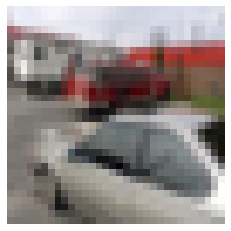

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data is a tuple (image, label)
image = data[0]

# Convert the tensor image to NumPy array and transpose the dimensions
image = image.numpy().transpose((1, 2, 0))

# Denormalize the image (if it was normalized during transformation)
mean = (0.5, 0.5, 0.5)  # Mean used for normalization
std = (0.5, 0.5, 0.5)  # Standard deviation used for normalization
image = image * std + mean

# Clip the pixel values to [0, 1] range in case of any numerical instability
image = np.clip(image, 0, 1)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.show()